# Imports & Setup

In [3]:
# pybotics imports
from pybotics import Robot, KinematicChain, LinkConvention, RobotOptimizationMask
from pybotics.calibration import compute_absolute_errors
from pybotics.robot_model import UR10

# arrays, vectors, and matrices
import numpy as np
np.set_printoptions(suppress=True)

# data display and visualization
import pandas as pd
pd.set_option('precision', 3)
from matplotlib import pyplot as plt
%matplotlib inline

# robot model copying for different stages
from copy import deepcopy

# calibration and optimization
import scipy.optimize
from sklearn.model_selection import train_test_split

# Initialize Robot Models

## Nominal Robot
- A nominal robot model represents what the robot manufacturer intended as a kinematic model
    - It is mathematically ideal

In [4]:
nominal_robot = UR10()

In [5]:
display(
    pd.DataFrame(
        nominal_robot.kinematic_chain.vector.reshape(nominal_robot.num_dof,-1),
        columns=('alpha', 'a', 'theta', 'd'))
)

,alpha,a,theta,d
0,0.000,0.0,0.000,118.0
1,1.571,0.0,3.142,0.0
2,0.000,612.7,0.000,0.0
3,0.000,571.6,0.000,163.9
4,-1.571,0.0,0.000,115.7
5,1.571,0.0,3.142,92.2


## *Real* Robot
- *Real* robots do not conform perfectly to the nominal parameters
- Sources of errors include, but are not limited to:
    - Kinematic errors
        - Mechanical tolerances
        - Angle offsets
    - Non-kinematic errors
        - Joint stiffness
        - Gravity
        - Temperature
        - Friction

In [6]:
real_robot = deepcopy(nominal_robot)

# let's pretend our real robot has small joint offsets
joint_offset = np.deg2rad(0.1)

for link in real_robot.kinematic_chain.links:
    link.theta += joint_offset

# let's also pretend our robot has a small offset error that we will not account for
real_robot.kinematic_chain.links[-1].d += 1 # mm

display(
    pd.DataFrame(
        real_robot.kinematic_chain.vector.reshape(real_robot.num_dof,-1),
        columns=('alpha', 'a', 'theta', 'd'))
)

,alpha,a,theta,d
0,0.000,0.0,0.002,118.0
1,1.571,0.0,3.143,0.0
2,0.000,612.7,0.002,0.0
3,0.000,571.6,0.002,163.9
4,-1.571,0.0,0.002,115.7
5,1.571,0.0,3.143,93.2


# Get Data

## Random Joint Configurations

In [7]:
num_measures = 1000
joint_configurations = np.random.uniform(low=np.deg2rad(-60),
                                         high=np.deg2rad(60),
                                         size=(num_measures, nominal_robot.num_dof))

display(
    pd.DataFrame(
        joint_configurations,
        columns=['j_{}'.format(i) for i in range(nominal_robot.num_dof)]
    ).head()
)

,j_0,j_1,j_2,j_3,j_4,j_5
0,0.869,-0.058,-0.652,-1.006,0.078,-0.807
1,-0.237,0.639,0.437,0.539,0.265,-0.167
2,0.361,-0.306,-0.169,0.952,0.570,-0.174
3,0.101,0.183,-0.682,-0.957,-0.805,-0.655
4,0.848,-0.304,-0.447,0.590,-0.178,0.719


## Get *Real* (aka Measured) Poses
- In real life, these poses would be measured using metrology equipment (e.g., laser tracker, CMM)

In [8]:
measured_poses = np.array(list(map(real_robot.fk, joint_configurations)))
measured_positions = measured_poses[:, :-1, -1]

display(
    pd.DataFrame(
        measured_positions,
        columns=['{}'.format(e) for e in 'xyz']
    ).head()
)

,x,y,z
0,-551.027,-1052.523,547.065
1,-685.885,-96.387,-770.888
2,-928.559,-611.309,434.760
3,-1181.954,-351.840,197.420
4,-472.174,-924.248,571.998


## Split Calibration and Validation Measures

In [9]:
train_joints, test_joints, train_position, test_positions = train_test_split(joint_configurations,
                                                                             measured_positions,
                                                                             test_size=0.3)

# Get Nominal Position Errors
- These nominal model is our starting point for calibration

In [10]:
nominal_errors = compute_absolute_errors(nominal_robot, test_joints, test_positions)

display(pd.Series(nominal_errors).describe())

count    300.000
mean       3.967
std        0.449
min        2.303
25%        3.706
50%        4.017
75%        4.257
max        5.098
dtype: float64

# Calibration

## Initialize a Calibration Robot

In [11]:
calibration_robot = deepcopy(nominal_robot)

## Define Optimization Mask
- Not all the robot parameters need to be part of the optimization process
    - The calibration will be more efficient and effective with masked parameters
    - Parameter selection is outside the scope of this example

In [12]:
kinematic_chain_mask = np.zeros(shape=(calibration_robot.num_dof, LinkConvention.MDH.value), dtype=bool)
kinematic_chain_mask[:, 2] = True

display(kinematic_chain_mask)

calibration_robot.optimization_mask = RobotOptimizationMask(world_frame=False,
                                                            kinematic_chain=kinematic_chain_mask.ravel(),
                                                            tool=False)

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False]])

## Define a Fitness Function

In [13]:
def fitness_function(optimization_vector, robot, joints, positions):
    robot.apply_optimization_vector(optimization_vector)
    errors = compute_absolute_errors(robot, joints, positions)
    return errors

## Optimize

In [14]:
result = scipy.optimize.leastsq(func=fitness_function,
                                x0=calibration_robot.optimization_vector,
                                args=(calibration_robot,
                                      train_joints,
                                      train_position),
                                maxfev=50 # intentially limited for Travis CI
                               )

calibration_robot.apply_optimization_vector(result[0])

/Users/nicholas/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 50.
  warnings.warn(errors[info][0], RuntimeWarning)


In [15]:
display(
    pd.DataFrame(
        calibration_robot.kinematic_chain.vector.reshape(calibration_robot.num_dof, -1),
        columns=('alpha', 'a', 'theta', 'd'))
)

,alpha,a,theta,d
0,0.000,0.0,2.542e-03,118.0
1,1.571,0.0,3.143e+00,0.0
2,0.000,612.7,2.405e-03,0.0
3,0.000,571.6,9.973e-04,163.9
4,-1.571,0.0,2.453e-03,115.7
5,1.571,0.0,3.142e+00,92.2


# Results

In [16]:
calibrated_errors = compute_absolute_errors(calibration_robot, test_joints, test_positions)

display(pd.Series(calibrated_errors).describe())

count    300.000
mean       0.582
std        0.252
min        0.045
25%        0.369
50%        0.597
75%        0.785
max        1.158
dtype: float64

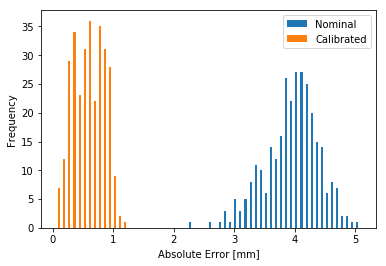

In [17]:
plt.hist(
    x=[nominal_errors,
       calibrated_errors],
    label=['Nominal', 'Calibrated'],
    bins=60,
);
plt.xlabel('Absolute Error [mm]');
plt.ylabel('Frequency');
plt.legend();

# Discussion
- A portion of the measured configurations and positions should be set aside for validation after calibration (i.e., optimization)
    - This is to check the optimized model for overfitting
- A calibrated robot model is never perfect in real life
    - The goal is often to reduce the max error under a desired threshold
- Small errors in the robot model can generate large errors in Cartesian position